# Problem 1

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


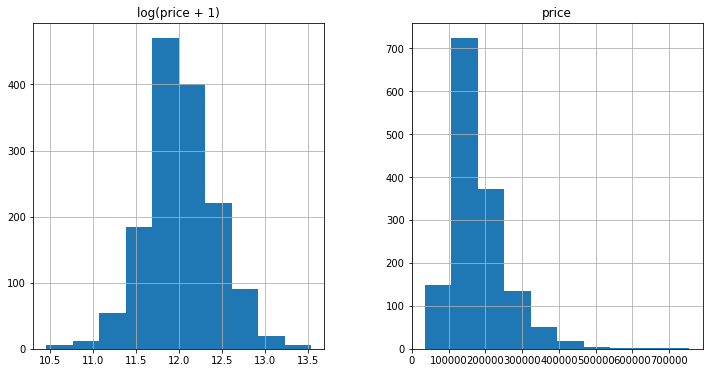

In [4]:
# Preprocess Data for SKLearn

train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

display(all_data.head())

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [70]:
# Ridge Regression Model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def gen_csv(filename, model):
    preds = np.expm1(model.predict(X_test))
    df = pd.DataFrame({"Id": test["Id"], "SalePrice": preds})
    display(df.head())
    df.to_csv(filename, encoding='utf-8', index=False)
    return preds
    

model_ridge = Ridge(0.1)
model_ridge.fit(X_train, y)

print("RMSE Error for a=1: {0}".format(rmse_cv(model_ridge).mean()))

ridge_a1_preds = gen_csv("out/df_a1.csv", model_ridge)

RMSE Error for a=1: 0.1377753827718782


,Id,SalePrice
0,1461,121519.486569
1,1462,159637.898351
2,1463,187900.728019
3,1464,200719.158085
4,1465,199280.934855


In [71]:
# Lasso Model

model_ridge_cv = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)
model_lasso_cv = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)

print("RMSE for Ridge regression: {0}".format(rmse_cv(model_ridge_cv).mean()))
print("RMSE for Lasso regression: {0}".format(rmse_cv(model_lasso_cv).mean()))

ridge_preds = gen_csv("out/df_best_ridge.csv", model_ridge_cv)
lasso_preds = gen_csv("out/df_best_lasso.csv", model_lasso_cv)

RMSE for Ridge regression: 0.1313618498939958
RMSE for Lasso regression: 0.1225673588504815


,Id,SalePrice
0,1461,120420.655489
1,1462,153867.564298
2,1463,185515.001785
3,1464,199064.684452
4,1465,201164.850838


,Id,SalePrice
0,1461,119958.035681
1,1462,151482.567322
2,1463,180200.853648
3,1464,197515.619193
4,1465,202434.157491


#### Kaggle Score for Best Ridge Regression
`0.12661`

#### Kaggle Score for Best Lasso Regression
`0.12096`

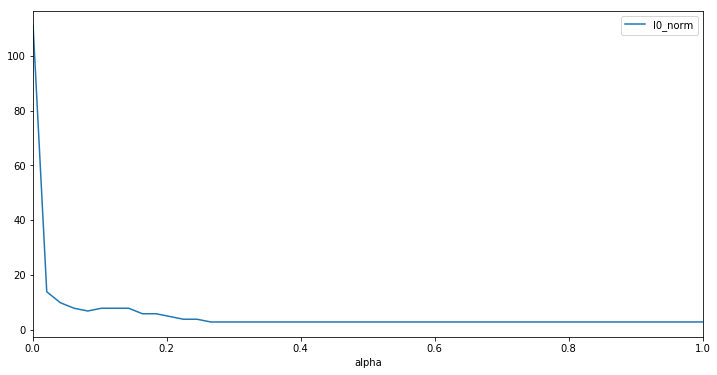

In [7]:
l0_norm = []

pnts = np.linspace(0.0005,1,50)
for alpha in pnts:
    m_r = Lasso(alpha).fit(X_train, y)
    l0_norm.append({"alpha": alpha, "l0_norm": sum(m_r.coef_ != 0)})

pd.DataFrame(l0_norm).set_index("alpha").plot()
plt.show()

In [111]:
# Ensembling
from mlxtend.regressor import StackingRegressor

X_ensemble_train = X_train.copy()
X_ensemble_train["ridge_prediction_1"] = model_ridge_cv.predict(X_train)
X_ensemble_train["lasso_prediction_1"] = model_ridge_cv.predict(X_train)

ridge_ensemble = RidgeCV(alphas = [2, 1, 0.1, 0.001, 0.0005], cv = 5).fit(X_ensemble_train, y)

X_ensemble_test = X_test.copy()
X_ensemble_test["ridge_prediction_1"] = model_ridge_cv.predict(X_test)
X_ensemble_test["lasso_prediction_1"] = model_lasso_cv.predict(X_test)

ensemble_preds = np.expm1(ridge_ensemble.predict(X_ensemble_test))
ensemble_df = pd.DataFrame({"Id": test["Id"], "SalePrice": ensemble_preds})

ensemble_df.to_csv("out/ensemble_df.csv", encoding='utf-8', index=False)

rmse = np.sqrt(-cross_val_score(ridge_ensemble, X_ensemble_train, y, scoring="neg_mean_squared_error", cv = 5))
print("Ensemble Model RMSE: {0}".format(rmse.mean()))

display(ensemble_df.head())

Ensemble Model RMSE: 0.12193529667842676


,Id,SalePrice
0,1461,120562.928600
1,1462,152865.778038
2,1463,183926.089607
3,1464,198646.918872
4,1465,201301.630835


#### Kaggle Score for Ensembling
`0.12348`

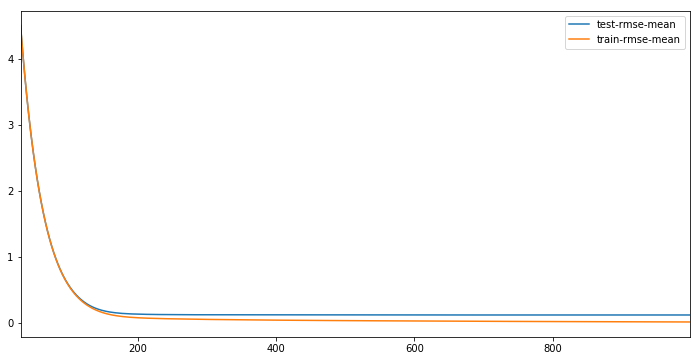

In [103]:
# XG BOOST
# First we need to tune parameters
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth': 5, 'eta':0.03, 'silent':1, 'objective':'reg:linear', 'colsample_bytree': 0.3, 'alpha':0}

cv_results = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=300, metrics="rmse", as_pandas=True, seed=123)

cv_results.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [104]:
model_xgb = xgb.XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=5, objective ='reg:linear') 
model_xgb.fit(X_train, y)

print("RMSE for XGB: {0}".format(rmse_cv(model_xgb).mean()))
xgb_preds = gen_csv("out/xgb_pred.csv", model_xgb)

RMSE for XGB: 0.12872432433086212


,Id,SalePrice
0,1461,121440.000000
1,1462,161743.687500
2,1463,186630.671875
3,1464,190171.953125
4,1465,184822.265625


#### Kaggle score for XG Boost
`0.13414`

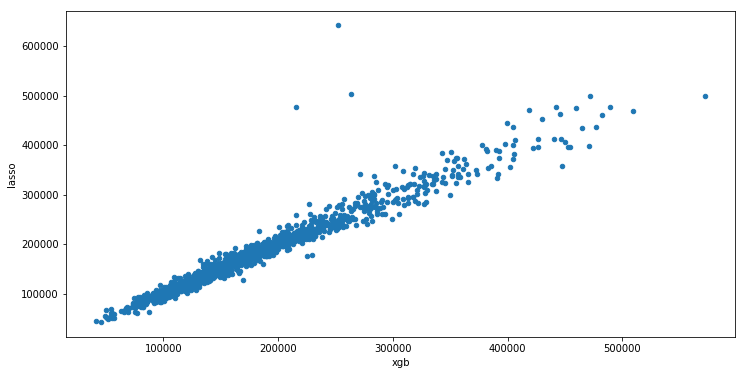

In [99]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
#Trying for best model
# Stack Lasso with XGB
from mlxtend.regressor import StackingCVRegressor

meta_model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5)

stacked = StackingRegressor(regressors=[model_xgb, model_lasso_cv], 
                           meta_regressor=meta_model)

stacked.fit(X_train, y)
print("RMSE for Stacked: {0}".format(rmse_cv(stacked).mean()))
stacked_preds = gen_csv("out/stacked_pred.csv", model_xgb)

#### Kaggle Score for Stacked
`0.13624`

While this seemed like a good idea in practice, the Kaggle Score is lower than just using the Lasso Model. To get a better result, we could explore different types meta models for training on the aggregated data.

In [107]:
# Alternate approach, average lasso and xgb predictions

best_df = pd.DataFrame({"Id": test["Id"], "SalePrice": 0.7*lasso_preds + 0.3*xgb_preds})

best_df.to_csv("out/df_best.csv", encoding='utf-8', index=False)

#### Kaggle Score for Averaging
`0.12021`

This was the best score we were able to get. We fine-tuned XBG to not overfit the data and then averaged the results with Lasso's predictions. In the plot of XGB predictions vs Lasso Predictions, we can see that there are some data points where the output of Lasso is wildly different from XGB, and by averaging the output from both models we are likely reducing those errors.

## Forum Reflection
We looked on the forum for inspiration when looking for the best method to perform our regression.  One that particularly stood out was a post by user MeiChengShih that detailed his stacking of 15 different models to optimize his result, and he showed that it significantly increased his score.  Looking forward to our final project and Kaggle competition, we will definitely consider such comprehensive stacking in our methodology.  He also detailed his use of outlier detection to improve his model.  He did this by finding a set of outliers to remove from his training set.  He then retrained his model using this new set and got a significantly better result.  Had the scope of this lab been greater, we may have implemented something like this.  Another example of this can be found in a post by user Andy Harless in which he exemplifies the importance of taking simple, logarithmic averages in order to improve your score. Finally, we were surprised in general at the wealth of knowledge contained in the posts.  Many people openly shared their thinking in regards to the competition, and in reading through them we were given a more realistic look at possible ways that we could take our future tasks. 

# Problem 2

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [52]:
# learn = create_cnn(data, models.resnet34, metrics=error_rate)
help(create_cnn)

path=untar_data(URLs.MNIST)

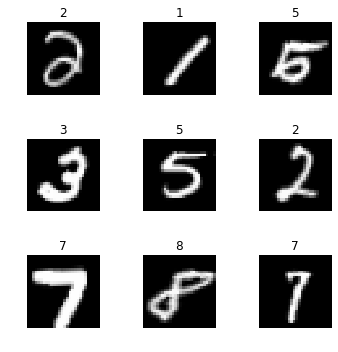

In [55]:
data = ImageDataBunch.from_folder(path, train="training", valid="testing", ds_tfms=get_transforms(do_flip=False), size=28)
data.show_batch(rows=3, figsize=(5,5))

In [76]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


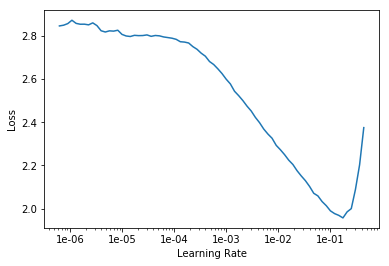

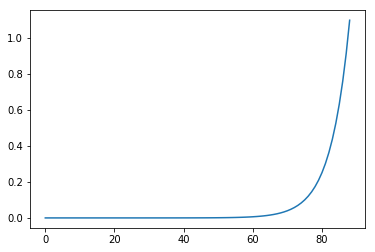

In [78]:
learn.recorder.plot()

plt.figure()
learn.recorder.plot_lr()

In [80]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.263670,0.155051,0.044000
2,0.119142,0.084666,0.023100
3,0.061374,0.027216,0.008600
4,0.037989,0.019857,0.006200


In [81]:
learn.save('stage-1')

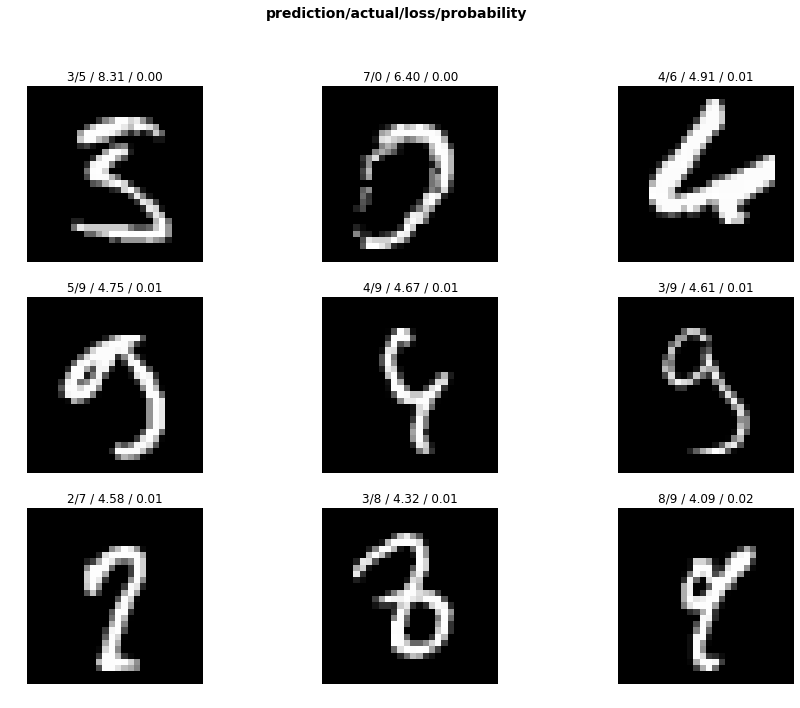

In [82]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,11))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


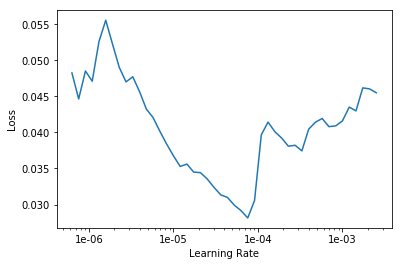

In [83]:
learn.unfreeze()
learn.fit_one_cycle(1)
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

In [84]:
# Final time fit based on learning rate slice

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.033732,0.021069,0.005600
2,0.024694,0.019311,0.006100
